In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import time
from numba import njit, prange

import numpy as np
import numpy.polynomial.legendre as leg
import numpy.linalg as linalg
from numpy.fft import rfft, rfftfreq
from scipy.integrate import simps

#### Abstract
This project derives and reproduces some of the results obtained in [Ref. 1](#ref), using their time-dependent generalized pseudospectral method (TDGPS) [[1]](#ref) to investigate the high harmonic generation (HHG) phenomenon. TDGPS makes it possible to solve the time-dependent Schrödinger equation directly without any restricted approximations. It turns out that this method is also more efficient than a traditional discretized scheme.

# I. Introduction
### A. High-order Harmonic Generation (HHG)


### B. Hartree Atomic Units (a.u.)
Atomic units are a system of natural units convenient for atomic physics calculations. Based on Gaussian units, the further defining constants are
* mass: $m_e\equiv1$
* charge: $e\equiv1$
* action: $\hbar\equiv1$

Some other important units are
* length: $a_0 = \frac { { \hbar  }^{ 2 } }{ { m }_{ e }{ e }^{ 2 } } =1$
* speed: $\alpha c = 1$ (i.e., speed of light  $c=\frac{1}{137}\,\mathrm{a.u.}$)
* energy: $\frac{e^2}{a_0}=1$ (i.e., the energy levels of a hydrogen atom $\mathcal{E}_{nlm}=-\frac{e^2}{2a_0}\frac{1}{n^2}=\frac{-0.5\,\mathrm{a.u.}}{n^2}$)

In this project, atomic units are used to calulate and present the results. 

### C. Quantum Mechanical Approach to HHG
Consider a hydrogen atom in an intense linearly polarized laser field $\mathbf{E}(t)=E_0f(t)\,\mathbf{e}_z$, where $f(t)$ is the pulse shape of the laser field. The potential energy stored between the dipole $\mathbf{D}=-eZ\,\mathbf{e}_z$ and the field $\mathbf{E}(t)$ is 

$$V(t)=-\mathbf{D}\cdot\mathbf{E}(t)\overset {\mathrm {a.u.} }{ = } E_0f(t)Z,$$

where $\mathbf{E}(t)$ is not quantized (i.e., not promoted to an operator) because we are dealing with an intense field. The Hamiltonian can therefore be expressed as 

$$H(t)=H_0+V(t)=\frac{P^2}{2m_e}-\frac{e^2}{R}+E_0f(t)Z.$$

From the above expression, it is clear that the Hamiltonian possesses rotational symmetry with respect to the $z$-axis, meaning $l_z=m\hbar$ is conserved. In other words, if a state $\left|\Psi(t)\right>$ starts out with a definite $m$, it will remain so for all $t$,

$$\left|\Psi(t)\right>=\left|A(t)\right>\left|m\right>\quad\overset { \left|r\theta\phi\right> }{ \longrightarrow  } \quad \Psi(\mathbf{r},t)=A(r,\theta,t)\,\Phi_m(\phi)=\frac{\psi(r,\theta,t)}{r}\,\Phi_m(\phi).$$

In light of this, we shall drop the $\phi$-dependence of the wave function and be focusing on the time propagation of $\psi(r,\theta,t)$. 

Suppose $A_{\mathcal{E}}(r,\theta)$ is one of the eigenfunctions of $H(t)$ at time $t$. The eigenvalue problem $H(\mathbf{r},t)\,A_{\mathcal{E}}(r,\theta)=\mathcal{E}\,A_{\mathcal{E}}(r,\theta)$ is hence

$$\left[ -\frac { { \hbar  }^{ 2 } }{ 2{ m }_{ e } } \left( \frac { 1 }{ { r }^{ 2 } } \frac { \partial  }{ \partial r } { r }^{ 2 }\frac { \partial  }{ \partial r } -\frac { { L }^{ 2 } }{ { \hbar  }^{ 2 }{ r }^{ 2 } }  \right) -\frac { { e }^{ 2 } }{ r } +V(r,\theta ,t) \right] A_{\mathcal{E}}(r,\theta)=\mathcal{E}\,A_{\mathcal{E}}(r,\theta).$$

Substituting $A_{\mathcal{E}}(r,\theta)=\frac{\psi_\mathcal{E}(r,\theta)}{r}$ and recasting the equation in atomic units, we obtain

$$\left[ -\frac { 1 }{ 2 } \frac { { \partial  }^{ 2 } }{ { \partial r }^{ 2 } } +\frac { { L }^{ 2 } }{ 2{ r }^{ 2 } } -\frac { 1 }{ r } +V(r,\theta ,t) \right] \psi_\mathcal{E}(r,\theta)=\mathcal{E}\,\psi_\mathcal{E}(r,\theta).$$

From the above equation, we can identify the unperturbed H-atom Hamiltonian $H_0(\mathbf{r})$ and the atom-field interaction $V(r,\theta,t)$ by

$$\begin{cases} H_0(\mathbf{r})=-\frac { 1 }{ 2 } \frac { { \partial  }^{ 2 } }{ { \partial r }^{ 2 } } +\frac { { L }^{ 2 } }{ 2{ r }^{ 2 } } -\frac { 1 }{ r }  \\ V(r,\theta ,t)= E_0f(t)\,r\cos\theta\end{cases}.$$

These two operators dominate the time propagation of a wave function $\psi(r,\theta,t)$, which can be obtained using the time-dependent generalized pseudospectral method (TDGPS) efficiently. We hence stop the introduction to the Schrödinger equation for HHG here.

To account for the power spectrum of HHG, we can start with the Larmor formula, the instantaneous radiative power emitted by an accelerating dipole,

$$P(t)=\frac{2}{3}\frac{q^2[a(t)]^2}{c^3}=\frac{2}{3}\frac{\left[\ddot{ d }(t)\right]^2}{c^3}.$$

Parseval's theorem states $\int _{ -\infty  }^{ \infty  }{ { \left| F(x) \right|  }^{ 2 }dx } =\int _{ -\infty  }^{ \infty  }{ { \left| \tilde { F } (k) \right|  }^{ 2 }dk } $. Since $F(t)=\frac { 1 }{ \sqrt { 2\pi  }  } \int _{ -\infty  }^{ \infty  }{ \tilde { F } (\omega )\,{ e }^{ i\omega t }d\omega  } $, we have $\tilde { F } (\omega )=\tilde { F } (-\omega )$ for real $F(t)$. Therefore,

$$\int _{ -\infty  }^{ \infty  }{ { P(t) }\,dt } =\frac { 2 }{ 3{ c }^{ 3 } } \int _{ -\infty  }^{ \infty  }{ { \left[{ \ddot { d }  }(t)\right] }^{ 2 } } dt=\frac { 2 }{ 3{ c }^{ 3 } } \int _{ -\infty  }^{ \infty  }{ { \left| { \ddot { d }  }(\omega ) \right|  }^{ 2 } } d\omega =\frac { 4 }{ 3{ c }^{ 3 } } \int _{ 0 }^{ \infty  }{ { \left| { \ddot { d }  }(\omega ) \right|  }^{ 2 } } d\omega. $$

Finally, if we associate the radiative energy spectrum $\mathcal{E}(\omega)$ with the power $P(t)$ by

$$\int _{ -\infty  }^{ \infty  }{ { P(t) }\,dt } =\int _{ 0 }^{ \infty  }{ \mathcal{E}(\omega) }\, d\omega, $$

then the average power spectrum during a time interval $[0,T]$ is just

$$P(\omega)=\frac{\mathcal{E}(\omega)}{T}=\frac{4}{3c^3T}{\left| { \ddot { d }  }(\omega ) \right| } ^{ 2 }.$$

Note that 

$$\begin{eqnarray}\ddot { d }(t)  & = & \frac { { d }^{ 2 } }{ { dt }^{ 2 } } \left[ \frac { 1 }{ \sqrt { 2\pi  }  } \int _{ -\infty  }^{ \infty  }{ d(\omega )\,{ e }^{ i\omega t }d\omega  }  \right] =\frac { 1 }{ \sqrt { 2\pi  }  } \int _{ -\infty  }^{ \infty  }{ -{ \omega  }^{ 2 }d(\omega )\,{ e }^{ i\omega t }d\omega  }  \\ \ddot { d }(t) & = & \frac { 1 }{ \sqrt { 2\pi  }  } \int _{ -\infty  }^{ \infty  }{ \ddot { d } (\omega )\,{ e }^{ i\omega t }d\omega  } , \end{eqnarray}$$

so $\ddot { d } (\omega )=-{ \omega  }^{ 2 }d(\omega )$. The formula for average power spectrum hence has two equivalent forms: length form and acceleration form,

$$\begin{cases} { P }_{\mathrm {len} }(\omega )=\frac { 4{ \omega  }^{ 4 } }{ 3{ c }^{ 3 }T } { \left| \mathcal{F} [\left< D(t) \right> ] \right|  }^{ 2 } \\ { P }_{ \mathrm{acc} }(\omega )=\frac { 4 }{ 3{ c }^{ 3 }T } { \left| \mathcal{F} [\left< \ddot { D } (t) \right> ] \right|  }^{ 2 } \end{cases},$$

where

$$\begin{eqnarray}\left< D(t) \right>&=&\left<\Psi(t)\right|(-eZ)\left|\Psi(t)\right>\overset{\mathrm{a.u.}}{=}-\left<\Psi(t)\right|Z\left|\Psi(t)\right>\\&=&-\int _{ 0 }^{ { r }_{\mathrm {max} } }{ \int _{ -1 }^{ 1 }{ ry \,{ \left| \psi (r,\theta ,t) \right|  }^{ 2 }dy  }\, dr } \quad\quad\quad(y\equiv\cos\theta),\end{eqnarray}$$

and 

$$\begin{eqnarray}\left<\ddot{D}(t)\right>&=&\left<\Psi\right|\left[-e\ddot{Z}(t)\right]\left|\Psi\right>=\left<\Psi(t)\right|\frac{-e}{m_e}\left[-\frac{e^2}{R^2}\frac{Z}{R}-eE_0f(t)\right]\left|\Psi(t)\right>\\&\overset{\mathrm{a.u.}}{=}&\left<\Psi(t)\right|\frac{Z}{R^3}\left|\Psi(t)\right>+E_0f(t)\\&=&\int _{ 0 }^{ { r }_{\mathrm{ max} } }{ \int _{ -1 }^{ 1 }{ \frac { { y } }{ { r }^{ 2 } } { \left| \psi (r,\theta ,t) \right|  }^{ 2 }dy }\, dr }+E_0f(t)\quad(y\equiv\cos\theta). \end{eqnarray}$$

Typical ${ r }_{\mathrm{ max}}$ used in the calculations of HHG can be ${ r }_{\mathrm{ max}}=150\sim 250 \,\,\mathrm{a.u.}$ If one decides to perform the Fourier transform by the *fast Fourier transform algorithm*, the relation between them must be considered: If we transform a function $F(t)$ by

$$\tilde F(\omega)=\frac { 1 }{ \sqrt { 2\pi  }  } \int _{ -\infty  }^{ \infty  }{  { F } (t )\,{ e }^{ -i\omega t }dt  },$$

then for $N$ data points in time domain,

$$\begin{eqnarray} \tilde { F } (k\Delta\omega)&\approx&\frac { 1 }{ \sqrt { 2\pi  }  } \sum _{ j=1 }^{ N }{ F(t_{ 0 }+j\Delta t)\,\,{ e }^{ -ik\Delta\omega(t_0+j\Delta t) }\,\Delta t }\quad\quad\quad\left(\Delta\omega\equiv\frac{2\pi}{N\Delta t}\right)\\
&=&\frac { 1 }{ \sqrt { 2\pi  }  }\,\Delta t\, { e }^{ -it_0k\Delta\omega } \sum _{ j=1 }^{ N }{ F(t_{ 0 }+j\Delta t)\,\,{ e }^{ -2\pi i\frac{jk}{N}}}\\
&=&\frac { 1 }{ \sqrt { 2\pi  }  }\,\Delta t\, { e }^{ -it_0k\Delta\omega }\,\, \mathrm{DFT}[F(t)].
\end{eqnarray}$$

Therefore, the formulas for average power spectrum will become

$$\begin{cases} { P }_{\mathrm {len} }(\omega )=\frac { 2{ \omega  }^{ 4 }{\Delta t}^2 }{ 3\pi{ c }^{ 3 }T }\, { \left| \mathrm{DFT} [\left< D(t) \right> ] \right|  }^{ 2 } \\ { P }_{ \mathrm{acc} }(\omega )=\frac { 2\, {\Delta t}^2}{ 3\pi{ c }^{ 3 }T }\, { \left| \mathrm{DFT} [\left< \ddot { D } (t) \right> ] \right|  }^{ 2 } \end{cases}.$$

Once the time-dependence of $\psi(r,\theta,t)$ is determined using TDGPS (See Sec. II), the HHG power spectrum will be readily available. The power spectra $P_\mathrm{len}(\omega)$ and $P_\mathrm{acc}(\omega)$ should be the same if the wavefunction $\psi(r,\theta,t)$ obtained is exactly the right solution. For periodic fields or continuous-wave lasers, we can further calculate the $n$th-order harmonic emission rate (the average number of photons emitted per unit time) by

$$\Gamma_n=\frac{P(n\omega_0)}{\hbar n \omega_0}\overset{\mathrm{a.u.}}{=}\frac{P(n\omega_0)}{ n \omega_0},$$

where $\omega_0$ is the fundamental frequency of the laser field.

# II. Mathematical Framework of TDGPS
### A. Split-operator Method
The time evolution of a state $\left|\Psi(t)\right>$ can generally be expressed as (in a.u.)

$$\left|\Psi(t)\right>=\mathcal{T}\left\{\exp\left[-i\int _{ 0 }^{ t }{ H(t' )\,dt'  } \right]\right\}\left|\Psi(0)\right>,$$

where $\mathcal{T}$ represents the time-ordering operation. The evolution between $t$ and $t+\Delta t$ is hence

$$\left|\Psi(t+\Delta t)\right>\,=\,\mathcal{T}\left\{\exp\left[-i\int _{ t }^{ t+\Delta t }{ H(t' )\,dt'  } \right]\right\}\left|\Psi(t)\right>\,\approx\,\mathcal{T}\left[e^{-iH(t)\Delta t}\right]\left|\Psi(t)\right>\,=\,e^{-iH(t)\Delta t}\left|\Psi(t)\right>.$$

If we split the Hamiltonian $H(t)$ into its kinetic energy part $K$ (consisting of momentum) and potential energy part $V$ (consisting of coordinates), then

$$\begin{eqnarray}e^{-iH(t)\Delta t}&=&e^{-i(K+V)\Delta t}=\exp\left[-i\frac{V}{2}\Delta t-i\left(K+\frac{V}{2}\right)\Delta t\right] \\  & = & \exp\left(-i\frac{V}{2}\Delta t\right)\,\exp\left[-i\left(K+\frac{V}{2}\right)\Delta t\right]\,\exp\left(\frac{1}{2}{\Delta t}^2\,[\frac{V}{2},K+\frac{V}{2}]\right)+\mathcal{O}({\Delta t}^3) \\&=&\exp\left(-i\frac{V}{2}\Delta t\right)\left\{\exp(-iK\Delta t)\,\exp\left(-i\frac{V}{2}\Delta t\right)\exp\left(\frac{1}{2}{\Delta t}^2\,[K,\frac{V}{2}]\right)+\mathcal{O}({\Delta t}^3)\right\}\exp\left(\frac{1}{2}{\Delta t}^2\,[\frac{V}{2},K]\right)+\mathcal{O}({\Delta t}^3)\\&=&e^{-iV\frac{\Delta t}{2}}\,e^{-iK\Delta t}\,e^{-iV\frac{\Delta t}{2}}+\mathcal{O}({\Delta t}^3).\end{eqnarray}$$

Substituting this back into the time evolution equation, we get

$$\left|\Psi(t+\Delta t)\right>\,=\,e^{-iV\frac{\Delta t}{2}}\,e^{-iK\Delta t}\,e^{-iV\frac{\Delta t}{2}}\left|\Psi(t)\right>+\mathcal{O}({\Delta t}^3).$$

The wave function can be obtained by inserting two identity operators:

$$\begin{eqnarray}\Psi(\mathbf{r},t+\Delta t)&=&\left<\textbf{r}\right|e^{-iV\frac{\Delta t}{2}}\left(\int { { d }^{ 3 }p }\,\left|\textbf{p}\right>\left<\textbf{p}\right|\right) e^{-iK\Delta t}\left(\int { { d }^{ 3 }r' }\,\left|\textbf{r}'\right>\left<\textbf{r}'\right|\right)e^{-iV\frac{\Delta t}{2}}\left|\Psi(t)\right>+\mathcal{O}({\Delta t}^3)\\
&=&e^{-iV(\textbf{r})\frac{\Delta t}{2}}\left[\int{{d}^{3}p}\,\left<\textbf{r} |\textbf{p}\right>e^{-iK(\textbf{p})\Delta t}\int{{d}^{3}r'}\,\left<\textbf{p} |\textbf{r}'\right>e^{-iV(\textbf{r}')\frac{\Delta t}{2}}\,\Psi(\textbf{r}',t)\right]+\mathcal{O}({\Delta t}^3)\\
&=&e^{-iV(\textbf{r})\frac{\Delta t}{2}}\left[\int{{d}^{3}p}\,\frac { { e }^{ { i\textbf{p}\cdot \textbf{r} }/{ \hbar  }  } }{ { (2\pi \hbar ) }^{ 3/2 } }\, e^{-iK(\textbf{p})\Delta t}\int{{d}^{3}r'}\,\frac { { e }^{ { -i\textbf{p}\cdot \textbf{r}' }/{ \hbar  }  } }{ { (2\pi \hbar ) }^{ 3/2 } }\,e^{-iV(\textbf{r}')\frac{\Delta t}{2}}\,\Psi(\textbf{r}',t)\right]+\mathcal{O}({\Delta t}^3)\\
&\overset{\mathrm{a.u.}}{=}&e^{-iV(\textbf{r})\frac{\Delta t}{2}}\left\{\frac { 1 }{ { (2\pi ) }^{ 3/2 } }\int{{ e }^{ { i\textbf{k}\cdot \textbf{r} }  }\, e^{-iK(\textbf{k})\Delta t}}\left[\frac { 1 }{ { (2\pi ) }^{ 3/2 } }\int{{ e }^{ { -i\textbf{k}\cdot \textbf{r}' }  }\,e^{-iV(\textbf{r}')\frac{\Delta t}{2}}\,\Psi(\textbf{r}',t)\,{d}^{3}r'}\right]{d}^{3}k\right\}+\mathcal{O}({\Delta t}^3)\\
&=&e^{-iV(\textbf{r})\frac{\Delta t}{2}}\,\,\mathcal{F}^{-1}\left\{e^{-iK(\textbf{k})\Delta t}\,\,\mathcal{F}\left[e^{-iV(\textbf{r}')\frac{\Delta t}{2}}\,\Psi(\textbf{r}',t)\right]\right\}+\mathcal{O}({\Delta t}^3).
\end{eqnarray}$$

Note that $K$ and $V$ are just some multiplication operations in their own spaces ($\textbf{p}$-space and $\textbf{r}$-space respectively), so the split-operator method does not require any computation of derivatives. Here is the summary of the algorithm:

1. Start with $\Psi(\textbf{r},t)$.
2. Propagate for a half time step $\frac{\Delta t}{2}$ in position space.
3. Perform Fourier transform.
4. Propagate for a full time step $\Delta t$ in momentum space.
5. Perform inverse Fourier transform.
6. Propagate for another half time step $\frac{\Delta t}{2}$ in position space.
7. End up with $\Psi(\textbf{r},t+\Delta t)$.

However, in TDGPS one adopts a different splitting scheme. The Hamiltonian is split (according to Sec. I. C.) into $H(t) = H_0+V(t)$. The split-operator method used in TDGPS is therefore 

$$\left|\Psi(t+\Delta t)\right>\,=\,e^{-iH_0\frac{\Delta t}{2}}\,e^{-iV(t)\Delta t}\,e^{-iH_0\frac{\Delta t}{2}}\left|\Psi(t)\right>+\mathcal{O}({\Delta t}^3),$$

or

$$\psi(r,\theta,t+\Delta t)\,=\,e^{-iH_0(\textbf{r})\frac{\Delta t}{2}}\,e^{-iV(r,\theta,t)\Delta t}\,e^{-iH_0(\textbf{r})\frac{\Delta t}{2}}\,\psi(r,\theta,t)+\mathcal{O}({\Delta t}^3).$$

### B. Expansion of $\psi(r,\theta,t)$ and the Time-independent Schrödinger Equation
Since any function of $\theta$ can be expanded in terms of the Legendre polynomials

$$P_l(\cos\theta)=\sqrt{\frac{4\pi}{2l+1}}\,\,Y_l^0(\theta),$$

we can expand $\psi(r,\theta,t)$ in terms of $P_l(\cos\theta)$:

$$\psi(r,y,t)=\sum _{ l=0 }^{ l_\mathrm{max} }{ g_l(r,t)\, P_l(y)}, $$

where $y\equiv\cos\theta$ and $l_\mathrm{max}=60$ in our implementation of TDGPS. The coefficients $g_l(r,t)$ can be determined accurately by the Gauss-Legendre quadrature:

$$\begin{eqnarray}g_l(r,t)&=&\left(l+\frac{1}{2}\right)\int _{ -1 }^{ 1 }{ P_l(y)\,\psi(r,y,t)\,dy } \\
&=&\left(l+\frac{1}{2}\right)\sum _{ j=1 }^{ M }{ w_j P_l(y_j)\,\psi(r,y_j,t)}, 
\end{eqnarray}$$

where $\{y_j\}$ are the $M$ zeros of the Legendre polynomial $P_M(y)$ and $\{w_j\}$ are the corresponding quadrature weights. The order of the Gauss-Legendre quadrature is chosen to be $M=l_\mathrm{max}=60$ in our program. 

Since $L^2\left|l,m\right>=l(l+1)\hbar^2\left|l,m\right>$, we have (in a.u.)

$$L^2(\theta,\phi)\,\,Y^0_l(\theta)=l(l+1)\,Y^0_l(\theta).$$

The $L^2(\theta,\phi)$ operator commutes with the other terms in $H_0(\textbf{r})$, meaning the first time step in energy space is

$$\begin{eqnarray}e^{-iH_0(\textbf{r})\frac{\Delta t}{2}}\,\psi(r,y,t)
&=&\sum _{ l=0 }^{ l_\mathrm{max} }{\exp\left[-i\left(-\frac { 1 }{ 2 } \frac { { \partial  }^{ 2 } }{ { \partial r }^{ 2 } } +\frac { { L }^{ 2 } }{ 2{ r }^{ 2 } } -\frac { 1 }{ r }\right)\frac{\Delta t}{2}\right]g_l(r,t)\,P_l(y)}
\\
&=&\sum _{ l=0 }^{ l_\mathrm{max} }{\left[e^{-iH_0^l(r)\frac{\Delta t}{2}}\,g_l(r,t)\right]P_l(y)}\\
&=&\sum _{ l=0 }^{ l_\mathrm{max} }{[S(l)\,g_l(r,t)]\,P_l(y)},
\end{eqnarray}$$

where $S(l)\equiv e^{-iH_0^l(r)\frac{\Delta t}{2}}$ and $H_0^l(r)=-\frac { 1 }{ 2 } \frac { { d  }^{ 2 } }{ { d r }^{ 2 } } +\frac { l(l+1) }{ 2{ r }^{ 2 } } -\frac { 1 }{ r }$. It is clear that each partial wave amplitude $g_l(r,t)$ evolves independently under individual $H_0^l$ energy subspaces. To compute $S(l)$, we have to solve the eigenvalue problem (i.e., the time-independent Schrödinger equation) first:

$$H_0^l(r)\,\chi^l(r)=\mathcal{E}^l\chi^l(r).$$

Now here comes the essence of the GPS method. We map the domain $[0, r_\max]$ into $[ - 1 , 1 ]$ by

$$r(x) = R\frac{1+x}{1-x+\alpha},$$

where $\alpha\equiv\frac{2R}{r_\max}$. The non-linear mapping is followed by the Legendre pseudospectral discretization (See Sec. II. C). This allows for denser grids near the origin, leading to more accurate eigenvalues and eigenfunctions and the use of a considerably smaller number of grid points than those of the equal-spacing grid methods. The mapping parameter is chosen to be $R=40$ in our program (Smaller $R$ leads to denser grids near $r=0$).

However, the introduction of non-linear mapping usually leads to either an asymmetric or a generalized eigenvalue problem. In order to avoid these undesirable features, we can define

$$\phi^l(x)=\sqrt{r'(x)}\,\,\chi^l(r)$$

such that

$$\begin{eqnarray}\frac{d^2\chi^l}{dr^2}
&=&\frac{d^2}{dr^2}\left(\frac{\phi^l}{\sqrt{r'}}\right) =\frac{1}{r'}\frac{d}{dx}\left(\frac{1}{r'}\frac{d}{dx}\frac{\phi^l}{\sqrt{r'}}\right)\\
&=&\frac{1}{r'}\frac{d}{dx}\left(-\frac{r''}{2\,{r'}^{2.5}}\phi^l+\frac{1}{{r'}^{1.5}}\frac{d\phi^l}{dx}\right) = \frac{1}{r'}\frac{d}{dx}\left[\frac{1}{\sqrt{r'}}\left(-\frac{r''}{2\,{r'}^{2}}\phi^l+\frac{1}{r'}\frac{d\phi^l}{dx}\right)\right]\\
&=&\frac{1}{r'}\frac{d}{dx}\left[\frac{1}{\sqrt{r'}}\left(\,\,\,\frac{d}{dx}\left(\frac{\phi^l}{r'}\right)+\frac{r''}{2\,{r'}^{2}}\phi^l\,\,\right)\right] = \frac{1}{r'}\frac{d}{dx}\left[\frac{1}{\sqrt{r'}}\frac{d}{dx}\left(\frac{\phi^l}{r'}\right)+\frac{1}{\sqrt{(2+\alpha)R}}\frac{\phi^l}{r'}\right]\\
&=& -\frac{r''}{2\,{r'}^{2.5}}\frac{d}{dx}\left(\frac{\phi^l}{r'}\right)+\frac{1}{{r'}^{1.5}}\frac{d^2}{dx^2}\left(\frac{\phi^l}{r'}\right)+\frac{1}{\sqrt{(2+\alpha)R}}\frac{1}{r'}\frac{d}{dx}\left(\frac{\phi^l}{r'}\right)\\
&=&\frac{1}{{r'}^{1.5}}\frac{d^2}{dx^2}\left(\frac{\phi^l}{r'}\right), \\
\end{eqnarray}$$

where we have used the identity $\frac{r''}{{r'}^{2.5}}=\frac{2}{\sqrt{(2+\alpha)R}}\frac{1}{r'}$. The original eigenvalue equation

$$\left[-\frac { 1 }{ 2 } \frac { { d  }^{ 2 } }{ { d r }^{ 2 } } +\frac { l(l+1) }{ 2{ r }^{ 2 } } -\frac { 1 }{ r }\right]\chi^l(r)=\mathcal{E}^l\chi^l(r)$$

is therefore transformed into

$$\left[-\frac { 1 }{ 2 }\frac { 1 }{ r'(x) } \frac { { d  }^{ 2 } }{ { d x }^{ 2 } }\frac { 1 }{ r'(x) } +\frac { l(l+1) }{ 2\,{ r }^{ 2 }(x) } -\frac { 1 }{ r(x) }\right]\phi^l(x)=\mathcal{E}^l\phi^l(x).$$

The transformed eigenvalue problem will turn out to be symmetric, as can be seen in Sec. II. C. The next task is to construct an accurate matrix representation of $H_0^l(x)=-\frac { 1 }{ 2 }\frac { 1 }{ r' } \frac { { d  }^{ 2 } }{ { d x }^{ 2 } }\frac { 1 }{ r' } +\frac { l(l+1) }{ 2{ r }^{ 2 } } -\frac { 1 }{ r }$, and then solve the symmetric eigenvalue problem.

### C. Legendre Pseudospectral Method
In this section, we explain how to construct a pseudospectral Legendre polynomial approximation to a derivative[[2,3]](#ref). Let $\{x_1,\,x_2,\,\dots ,\,x_N\}$ be a set of $N$ distinct collocation points, defined as the roots of $P'_{N+1}(x)=0$. The total number of grid points used in the calculations of HHG can be $N=200\sim 300$. Given the values of a function $f(x)$ at each grid point $x_j$, we construct the interpolation polynomial

$$I_Nf(x)=\sum _{ j=1 }^{ N }{ f(x_j)\,C_j(x) }, $$

where the cardinal function is defined by

$$C_j(x)=\frac{-1}{(N+1)(N+2)\,P_{N+1}(x_j)}\frac{\left(1-x^2\right)P'_{N+1}(x)}{x-x_j}.$$

If we let $F(x)=\left(1-x^2\right)P'_{N+1}(x)$, then, according to the Legendre differential equation

$$\frac{d}{dx}\left[\left(1-x^2\right)\frac{dP_{l}}{dx}\right]+l(l+1)P_l=0,$$

or

$$F'=-(N+1)(N+2)\,P_{N+1},$$

the cardinal function can be expressed as

$$C_j(x)=\frac{F(x)}{(x-x_j)\,F'(x_j)}.$$

We can easily find out that since $F(x_k)=0$, we have $C_j(x_k)=0$ for $k\neq j$. For the case $k=j$, we calculate with L'Hospital's rule:

$$C_j(x_j)=\lim _{ x\rightarrow x_j }{ \frac{F(x)}{x-x_j}\frac{1}{F'(x_j)} }=1. $$

Therefore, we have verified the conditions for a cardinal function of interpolation, i.e.,

$$C_j(x_k)=\delta_{jk}.$$

To compute the first derivative of $I_Nf$ at $x_k$, the interpolation formula is differentiated yielding

$$\left. \frac{d}{dx}I_Nf\,\right|_{x_k}=\sum _{ j=1 }^{ N }{ f(x_j)\,C'_j(x_k) } =\sum _{ j=1 }^{ N }{(\mathcal{D})_{kj}\,\textbf{f}_j},$$

where $\textbf{f}=(\,f(x_1),\,f(x_2),\,\dots,\,f(x_N)\,)$ and the approximated derivative is $\mathcal{D}\textbf{f}=(\left.\frac{df}{dx}\right|_{x_1},\,\left.\frac{df}{dx}\right|_{x_2},\,\dots,\,\left.\frac{df}{dx}\right|_{x_N})$. The operator $\mathcal{D}$ is the $N\times N$ differentiation matrix, defined by $(\mathcal{D})_{kj}=C'_j(x_k)$. By differentiating the formula for the cardinal function

$$\begin{eqnarray}C_j'(x)&=&\frac{F'(x)\,(x-x_j)\,F'(x_j)-F(x)\,F'(x_j)}{(x-x_j)^2\left[F'(x_j)\right]^2}=\frac{1}{x-x_j}\left[\frac{F'(x)}{F'(x_j)}-C_j(x)\right] \\
&=&\frac{1}{x-x_j}\left[\frac{P_{N+1}(x)}{P_{N+1}(x_j)}-C_j(x)\right],
\end{eqnarray}$$

we can construct the differentiation matrix

$$(\mathcal{D})_{kj}=C'_j(x_k)=\begin{cases}\frac{P_{N+1}(x_k)}{P_{N+1}(x_j)}\frac{1}{x_k-x_j}&k\neq j \\ 
\underset{x\rightarrow x_j}{\lim}  \frac{{P_{N+1}(x)}\,/\,{P_{N+1}(x_j)}\,\,-\,\,1}{x-x_j}=\frac{P'_{N+1}(x_j)}{P_{N+1}(x_j)}=0\quad&k=j \end{cases}.$$

Similarly, to compute the second-order derivative of $I_Nf$ at $x_k$, the interpolation formula is differentiated again yielding

$$\left. \frac{d^2}{dx^2}I_Nf\,\right|_{x_k}=\sum _{ j=1 }^{ N }{ f(x_j)\,C''_j(x_k) } =\sum _{ j=1 }^{ N }{(\mathcal{D}^2)_{kj}\,\textbf{f}_j},$$

where $\mathcal{D^2}\textbf{f}=(\left.\frac{d^2f}{dx^2}\right|_{x_1},\,\left.\frac{d^2f}{dx^2}\right|_{x_2},\,\dots,\,\left.\frac{d^2f}{dx^2}\right|_{x_N})$ is the approximated derivative and $\mathcal{D}^2$ is the $N\times N$ second-order differentiation matrix, defined by $(\mathcal{D}^2)_{kj}=C''_j(x_k)$. By again differentiating the formula for the cardinal function

$$C_j''(x)=\frac{1}{x-x_j}\left[\frac{P'_{N+1}(x)}{P_{N+1}(x_j)}-2C'_j(x)\right],$$

we can see that, for $k\neq j$,

$$(\mathcal{D}^2)_{kj}=C''_j(x_k)=-2\frac{P_{N+1}(x_k)}{P_{N+1}(x_j)}\frac{1}{(x_k-x_j)^2}.$$

For $k=j$,

$$C''_j(x_j)=\lim_{x\rightarrow x_j}{\frac{\frac{P'_{N+1}(x)}{P_{N+1}(x_j)}-2C'_j(x)}{x-x_j}}=\frac{P''_{N+1}(x_j)}{P_{N+1}(x_j)}-2C''_j(x_j),$$

so $C''_j(x_j)=\frac{1}{3}\frac{P''_{N+1}(x_j)}{P_{N+1}(x_j)}$. According to the Legendre differential equation

$$\left(1-x^2\right)P''_{N+1}-2xP'_{N+1}+(N+1)(N+2)\,P_{N+1}=0,$$

we have $\frac{P''_{N+1}(x_j)}{P_{N+1}(x_j)}=-\frac{(N+1)(N+2)}{1-x_j^2}$. The second-order differentiation matrix is hence

$$(\mathcal{D}^2)_{kj}=C''_j(x_k)=\begin{cases}-2\frac{P_{N+1}(x_k)}{P_{N+1}(x_j)}\frac{1}{(x_k-x_j)^2}&k\neq j \\ 
-\frac{1}{3}\frac{(N+1)(N+2)}{1-x_j^2}&k=j \end{cases}.$$

Now we are well-prepared for the discretization of the eigenvalue problem

$$\left[-\frac { 1 }{ 2 }\frac { 1 }{ r' } \frac { { d  }^{ 2 } }{ { d x }^{ 2 } }\frac { 1 }{ r' } +V^l(x)\right]\phi^l(x)=\mathcal{E}^l\phi^l(x),$$

where $V^l(x)\equiv\frac { l(l+1) }{ 2{ r }^{ 2 } } -\frac { 1 }{ r }$. The discretized eigenfunction is $\boldsymbol{\phi}^l=(\,\phi^l(x_1),\,\phi^l(x_2),\,\dots,\,\phi^l(x_N)\,)$. Recasting the eigenvalue equation in the discretized form, we get

$$\begin{eqnarray}&\mathcal{E}^l&\boldsymbol{\phi}^l\\&=&\left\{\,\,\begin{bmatrix} -\frac { 1 }{ 2 } \frac { 1 }{ r'(x_{ 1 }) }  &  &  \\  & \ddots  &  \\  &  & -\frac { 1 }{ 2 } \frac { 1 }{ r'(x_{ N }) }  \end{bmatrix}\,\mathcal{D}^{ 2 }\,\begin{bmatrix} \frac { 1 }{ r'(x_{ 1 }) }  &  &  \\  & \ddots  &  \\  &  & \frac { 1 }{ r'(x_{ N }) }  \end{bmatrix}\,+\,\begin{bmatrix} V^{ l }(x_{ 1 }) &  &  \\  & \ddots  &  \\  &  & V^{ l }(x_{ N }) \end{bmatrix}\,\,\right\}\boldsymbol{\phi}^l\\
&=&\left\{\begin{bmatrix} P_{ N+1 }(x_{ 1 }) &  &  \\  & \ddots  &  \\  &  & P_{ N+1 }(x_{ N }) \end{bmatrix}\begin{bmatrix} \frac { 1 }{ r'(x_{ 1 }) } \frac { (N+1)(N+2) }{ 6(1-x_{ 1 }^{ 2 }) } \frac { 1 }{ r'(x_{ 1 }) }  & \frac { 1 }{ r'(x_{ 1 }) } \frac { 1 }{ { (x_{ 1 }-x_{ 2 }) }^{ 2 } } \frac { 1 }{ r'(x_{ 2 }) }  & \cdots  \\ \frac { 1 }{ r'(x_{ 2 }) } \frac { 1 }{ { (x_{ 2 }-x_{ 1 }) }^{ 2 } } \frac { 1 }{ r'(x_{ 1 }) }  & \vdots  & \cdots  \\ \vdots  & \vdots  & \cdots  \end{bmatrix}\begin{bmatrix} \frac { 1 }{ P_{ N+1 }(x_{ 1 }) }  &  &  \\  & \ddots  &  \\  &  & \frac { 1 }{ P_{ N+1 }(x_{ N }) }  \end{bmatrix}+\begin{bmatrix} V^{ l }(x_{ 1 }) &  &  \\  & \ddots  &  \\  &  & V^{ l }(x_{ N }) \end{bmatrix}\right\}\boldsymbol{\phi}^l
\end{eqnarray}$$

If we multiply the matrix 

$$\begin{bmatrix} \frac { 1 }{ P_{ N+1 }(x_{ 1 }) }  &  &  \\  & \ddots  &  \\  &  & \frac { 1 }{ P_{ N+1 }(x_{ N }) }  \end{bmatrix}$$

to the left of both sides, then we obtain a symmetric eigenvalue problem

$$\begin{bmatrix} \frac { 1 }{ r'(x_{ 1 }) } \frac { (N+1)(N+2) }{ 6(1-x_{ 1 }^{ 2 }) } \frac { 1 }{ r'(x_{ 1 }) } +V^{ l }(x_{ 1 }) & \frac { 1 }{ r'(x_{ 1 }) } \frac { 1 }{ { (x_{ 1 }-x_{ 2 }) }^{ 2 } } \frac { 1 }{ r'(x_{ 2 }) }  & \cdots  \\ \frac { 1 }{ r'(x_{ 2 }) } \frac { 1 }{ { (x_{ 2 }-x_{ 1 }) }^{ 2 } } \frac { 1 }{ r'(x_{ 1 }) }  & \vdots  & \cdots  \\ \vdots  & \vdots  & \cdots  \end{bmatrix}\boldsymbol{\xi} ^{ l }=\mathcal{E}^{ l }\boldsymbol{\xi} ^{ l },$$

where the eigenvector $\boldsymbol{\xi} ^{ l }=(\frac{\phi^l(x_1)}{P_{N+1}(x_1)},\,\frac{\phi^l(x_2)}{P_{N+1}(x_2)},\,\dots,\,\frac{\phi^l(x_N)}{P_{N+1}(x_N)})$. The matrix elements of the Hamiltonian are

$$\left(H_0^l\right)_{jk}=\begin{cases}\frac { 1 }{ r'(x_{ j }) } \frac { 1 }{ { (x_{ j }-x_{ k }) }^{ 2 } } \frac { 1 }{ r'(x_{ k }) } &j\neq k \\ 
\frac { 1 }{ r'(x_{ j }) } \frac { (N+1)(N+2) }{ 6(1-x_{ j }^{ 2 }) } \frac { 1 }{ r'(x_{ j }) } +V^{ l }(x_{ j })&j=k \end{cases}.$$

The symmetry of $H_0^l$ makes $\left\{\boldsymbol{\xi}_1 ^{ l },\,\boldsymbol{\xi}_2 ^{ l },\,\dots,\,\boldsymbol{\xi}_N^{ l }\right\}$ an orthonormal complete set. Therefore, we are finally able to perform the time step in energy subspaces:

$$S(l)= e^{-iH_0^l\frac{\Delta t}{2}}=Q(l)\,\,\Lambda(l)\,\, [Q(l)]^\mathrm{T},$$

where $Q(l)$ is formed by plugging the eigenvectors $\left\{\boldsymbol{\xi}_j ^{ l }\right\}$ into its columns and

$$\Lambda(l)=\begin{bmatrix} { e }^{ -i\mathcal{E}_1^l\frac { \Delta t }{ 2 }  } &  &  \\  & \ddots  &  \\  &  & { e }^{ -i\mathcal{E}_N^l\frac { \Delta t }{ 2 }  } \end{bmatrix}.$$

Note that $S(l)$ (resulting from the time-independent Schrödinger equation) needs to be computed only once throughout the program. One should be careful of the transformation of wave functions (or eigenfunctions) when propagating them in the energy space (cf. the Fourier transform in the traditional split-operator method). For example, let the ground state energy be $\mathcal{E}_1^0$ and its corresponding eigenvector $\boldsymbol{\xi}_1 ^{ 0 }$. Since

$$\chi^l(r(x))=\frac{\phi^l(x)}{\sqrt{r'(x)}}=\frac{P_{N+1}(x)}{\sqrt{r'(x)}}\,\xi^l(x),$$

the transformation of $\boldsymbol{\xi}_1 ^{ 0 }$ back to the coordinate space is

$$\chi_1^0\left(r(x_j)\right)=\frac{P_{N+1}(x_j)}{\sqrt{r'(x_j)}}\,\xi_1^0(x_j),$$

and $\left\{\chi_1^0\left(r(x_j)\right)\right\}$ is just the (unnormalized) radial ground state wave function evaluated at those grid points.

In [2]:
def Vl(r,l):
    return l*(l+1)/(2*r**2) - 1/r

@njit(parallel=True)
def r(x):
    α = 2*R/r_max
    return R*(1+x)/(1-x+α)

def r_prime(x):
    α = 2*R/r_max
    return (2+α)*R/(1-x+α)**2

E0 = (5*10**13/(3.51*10**16))**0.5
ω0 = 800/1064*0.057
τ = 2*np.pi/ω0
n = 60

Up = E0**2/(4*ω0**2)
ϵ_cut = 10
ϵ_max = 2*ϵ_cut
r_cut = 60
r_max = 200
N = 300
l_max = 60
R = 40
dt = τ/1000

x = leg.legroots(leg.legder([0]*(N+1)+[1]))
S = np.zeros((l_max+1,N,N), dtype='complex')
for l in range(l_max+1):
    H0 = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            if i==j: H0[i,j] = (N+1)*(N+2)/(r_prime(x[i])**2 * 6*(1-x[i]**2)) + Vl(r(x[i]), l)
            else: H0[i,j] = 1/(r_prime(x[i]) * r_prime(x[j]) * (x[i]-x[j])**2)
    ϵ, Q = linalg.eigh(H0)
    ϵ_absorber = np.heaviside(ϵ_cut-ϵ,0) + np.heaviside(ϵ-ϵ_cut,1)*np.heaviside(ϵ_max-ϵ,0) * \
                 np.sin(np.pi*(ϵ-(2*ϵ_cut-ϵ_max))/(2*(ϵ_max-ϵ_cut)))**2
    Λ = np.diag(np.exp(-0.5j*dt*ϵ) * ϵ_absorber)
    S[l] = Q @ Λ @ Q.T
    if l==0: ξ0 = Q[:,0]

/Users/quincylin/anaconda3/lib/python3.6/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "<ipython-input-2-296483e0b5b8>", line 5:
@njit(parallel=True)
def r(x):
^

  state.func_ir.loc))


### D. Summary of the TDGPS Routine
1. Solve the discretized time-independent Schrödinger equation at the grid points $\left\{x_j\right.\left|P'_{N+1}(x_j)=0\right\}$ for eigenvalues $\left\{\mathcal{E}_j ^{ l }\right\}$ and eigenvectors $\left\{\boldsymbol{\xi}_j^l\right\}$ of $H_0^l$. Then compute $S(l)=Q(l)\,\Lambda(l)\, [Q(l)]^\mathrm{T}$.

2. Set up a normalized initial wave function to be propagated. Note that the wave function should be expanded (as in Sec. II. B), and the radial parts $g_l(r(x_j),t=0)$ should be transformed to the energy space (spanned by $\left\{\boldsymbol{\xi}_j^l\right\}$) first. In our program, we let the system start out at the ground state $\boldsymbol{\xi}^0_1$, i.e.,
$$\begin{cases}\boldsymbol{\xi}^{l=0}[\mathrm{step\,0}]\equiv\boldsymbol{\xi}^0_1  \\ \boldsymbol{\xi}^{l\neq0}[\mathrm{step\,0}]\equiv0 \end{cases} \quad\mathrm{at}\,\, t=0.$$
3. Propagate for a half time step $\frac{\Delta t}{2}$ in energy subspaces by 
$$\boldsymbol{\xi}^l[\mathrm{step\,1}]=S(l)\,\,\boldsymbol{\xi}^{l}[\mathrm{step\,0}].$$
4. Transform $\boldsymbol{\xi}^l[\mathrm{step\,1}]$ back to the coordinate space (spanned by $\left\{\boldsymbol{\chi}_j^l(x)\right\}$), i.e., $g_l=\frac{P_{N+1}(x)}{\sqrt{r'(x)}}\,\xi^l[\mathrm{step\,1}]$, and recover the wave function by
$$\psi[\mathrm{step\,1}]=\sum _{ l=0 }^{ l_\mathrm{max} }{ g_l(r(x),t)\, P_l(y)}.$$
5. Propagate for a full time step $\Delta t$ in coordinate space by 
$$\psi[\mathrm{step\,2}]=e^{-iV(r(x),y,t)\Delta t}\psi[\mathrm{step\,1}].$$
6. Expand $\psi[\mathrm{step\,2}]$ in terms of $P_l(y)$, and then transform the radial parts $g_l$ to the energy space, i.e., $\xi^l[\mathrm{step\,2}]=\frac{\sqrt{r'(x)}}{P_{N+1}(x)}\,g_l$. Note that an sine-squared-form absorber is applied here to filter out the wavepacket reaching the outward boundary $r_\max$ to avoid artificial reflection. The idea is also commonly used in other numerical propagation methods: After each time step, multiply the wave function that comes close to the boundary by some function that goes gently to $0$ towards the box boundaries.

7. Propagate for another half time step $\frac{\Delta t}{2}$ in energy subspaces by 
$$\boldsymbol{\xi}^l[\mathrm{step\,3}]=S(l)\,\,\boldsymbol{\xi}^{l}[\mathrm{step\,2}].$$
8. Repeat 3–7 until $t=t_f$. Since we end up in the energy space, we have to perform another transformation (as in 4.) to get $\psi(r,y,t_f)$.

In [3]:
@njit(parallel=True)
def legval(x,n):
    '''x = vector-like array'''
    X = x.copy().reshape(1,x.size)
    P = np.concatenate((np.ones((1,x.size)),X),axis=0)
    for i in range(2,n+1):
        P_i = ((2*i-1)*X*P[i-1] - (i-1)*P[i-2])/i
        P = np.append(P, P_i, axis=0)
    return P

trans = legval(x,N+1)[-1]/np.sqrt(r_prime(x))
g0 = ξ0*trans
norm = np.sum(simps(g0*g0.conj(),r(x))*2)**0.5
ξ = np.zeros((l_max+1,N), dtype=np.complex128)
ξ[0] = g0/norm/trans

@njit
def ξ2g(ξ):
    g = ξ*trans*r_absorber
    return g

@njit(parallel=True)
def ξ1(ξ):
    output = np.zeros((l_max+1,N), dtype=np.complex128)
    for l in prange(l_max+1):
        output[l] = S[l] @ ξ[l]
    return output

order = l_max
roots, weights = leg.leggauss(order)
roots.shape = (order,1,1)
weights.shape = (order,1)
legroots = legval(roots,l_max)
r_absorber = np.heaviside(r_cut-r(x),0) + \
             np.heaviside(r(x)-r_cut,1) * np.sin(np.pi*(r(x)-(2*r_cut-r_max))/(2*(r_max-r_cut)))**2

@njit
def E(t):
    if 0<=t<=n*τ: 
        return E0 * np.sin(np.pi*t/(n*τ))**2 * np.sin(ω0*t)
    else: 
        return 0

@njit
def ξ3(g1,t):
    V = E(t) * r(x) * roots
    g2 = np.exp(-1j*dt*V) * g1
    ψ = (g2*legroots.T.reshape(order,l_max+1,1)).sum(axis=1)
    
    g = np.zeros((l_max+1,N), dtype=np.complex128)
    for l in range(l_max+1):
        quad = (ψ * legroots[l].reshape(order,1) * weights).sum(axis=0)
        g[l] = (l+0.5)*quad
    
    ξ = g/trans
    for l in range(l_max+1):
        ξ[l] = S[l] @ ξ[l]
    
    return ξ

@njit
def integrand(g):
    ψ = (g*legroots.T.reshape(order,l_max+1,1)).sum(axis=1)
    quad = (roots.reshape(order,1)*(ψ*ψ.conj())*weights).sum(axis=0)
    len_form = -quad*r(x)
    acc_form = quad/r(x)**2
    return len_form, acc_form

t_max = n*τ
D_len = np.array([])
D_acc = np.array([])
survival = np.array([])
t = 0

start = time.time()
while t<t_max:
    ξ = ξ3(ξ2g(ξ1(ξ)),t)
    t += dt
    g = ξ2g(ξ)
    norm2 = (simps(g*g.conj(),r(x),axis=-1) * 2/(2*np.arange(l_max+1)+1)).sum()
    survival = np.append(survival, norm2)
    integrands = integrand(g)
    D_len = np.append(D_len, simps(integrands[0],r(x)))
    D_acc = np.append(D_acc, simps(integrands[1],r(x)) + E(t)*norm2)
end = time.time()
print("Elapsed time = %d min %d sec" % ((end-start)//60,(end-start)%60))

Elapsed time = 103 min 15 sec


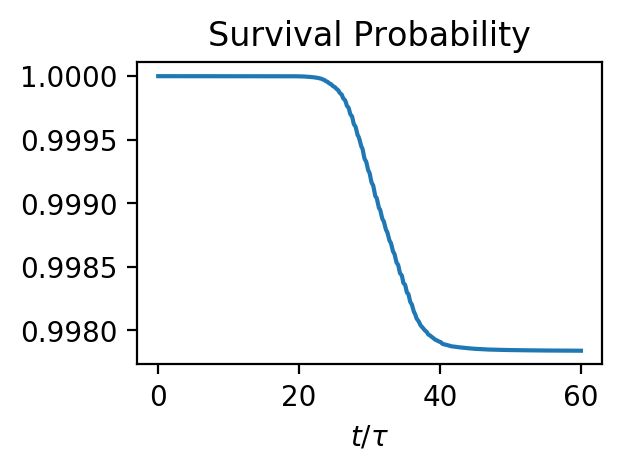

In [4]:
plt.figure(figsize=(3,2),dpi=200)
plt.plot(np.arange(len(survival))*dt/τ, survival.real)
plt.xlabel('$t/τ$')
plt.title('Survival Probability')
plt.show()

# III. Results and Discussion
We consider the application of the technique to the study of HHG driven by an ultra-short intense laser field. The electric field of the pulse used in the investigation has the following time-dependent form:

$$E(t) = E_0f(t)=E_0\sin^2\left(\frac{\pi t}{n\tau}\right)\sin\left(\omega_0 t\right)\quad\quad 0\le t \le n\tau,$$

where $n$ is the pulse length measured in optical cycle (the fundamental period of the laser) $\tau = \frac{2\pi}{\omega_0}$ and is set to be $n=60$ (pulse duration ~ 200 fs). Given below are some results for the case of linearly polarized pulsed field with intensity $5\times10^{13}\, \mathrm{W/cm^2}$ and wavelength $1064\, \mathrm{nm}$.

Since $I(t)=c\epsilon_0[E(t)]^2$, the above intensity is converted to $E_0$ according to the formula

$$\left<I(t)\right>=c\epsilon_0E_0^2\left<\sin^2(\omega_0 t)\right>=\frac{1}{2}c\epsilon_0E_0^2.$$

The following top two plots show the induced dipole moments in length and acceleration forms, $\left< D(t) \right>$ and $\left< { \ddot { D }  }(t) \right>$, respectively as a function of time (in optical cycles $n=\frac{t}{\tau}$). The power spectra are obtained from the length/acceleration-form formulas. The results, as a function of frequency (in harmonic orders $\nu=\frac{\omega}{\omega_0}$), are shown in the bottom plot. It is seen that the length-form power spectrum $P_{\mathrm {len}}(\omega )$ and the acceleration-form power spectrum $P_{\mathrm {acc}}(\omega )$ are nearly identical for all the fine details of line shapes for each harmonic peak. This justifies further the accuracy and computational advantages ($\Delta t=0.1$ is good enough) of the time-dependent split-operator technique with the *pseudospectral radial discretization and energy representation*. We note that the predicted cut-off harmonic order ($\nu = 35$) is larger than that predicted by the semi-classical model ($\nu\approx27$). This is consistent with the fact that the Keldysh parameter for this case is $\gamma = 1.13$, indicating that HHG is likely to be produced by the multiphoton excitation mechanism rather than by the tunneling mechanism.

To check the validity of the time-propagation method, we can evaluate the *survival probability* of the electron. When there is no field present ($f(t)=0$), the probability should be very close to $1$. If the probability goes too small after the propagation, it might indicate that the absorber filters out too much wavepacket where the important physics occurs. The *survival probability* at time $t$ is defined as

$$\left<\Psi(t)\right|\left.\Psi(t)\right> =  \int _{ 0 }^{ r_\max }{ \int _{ -1 }^{ 1 }{\psi^\ast (r,y,t)\,\,\psi(r,y,t)\, dy\,dr }  }.$$

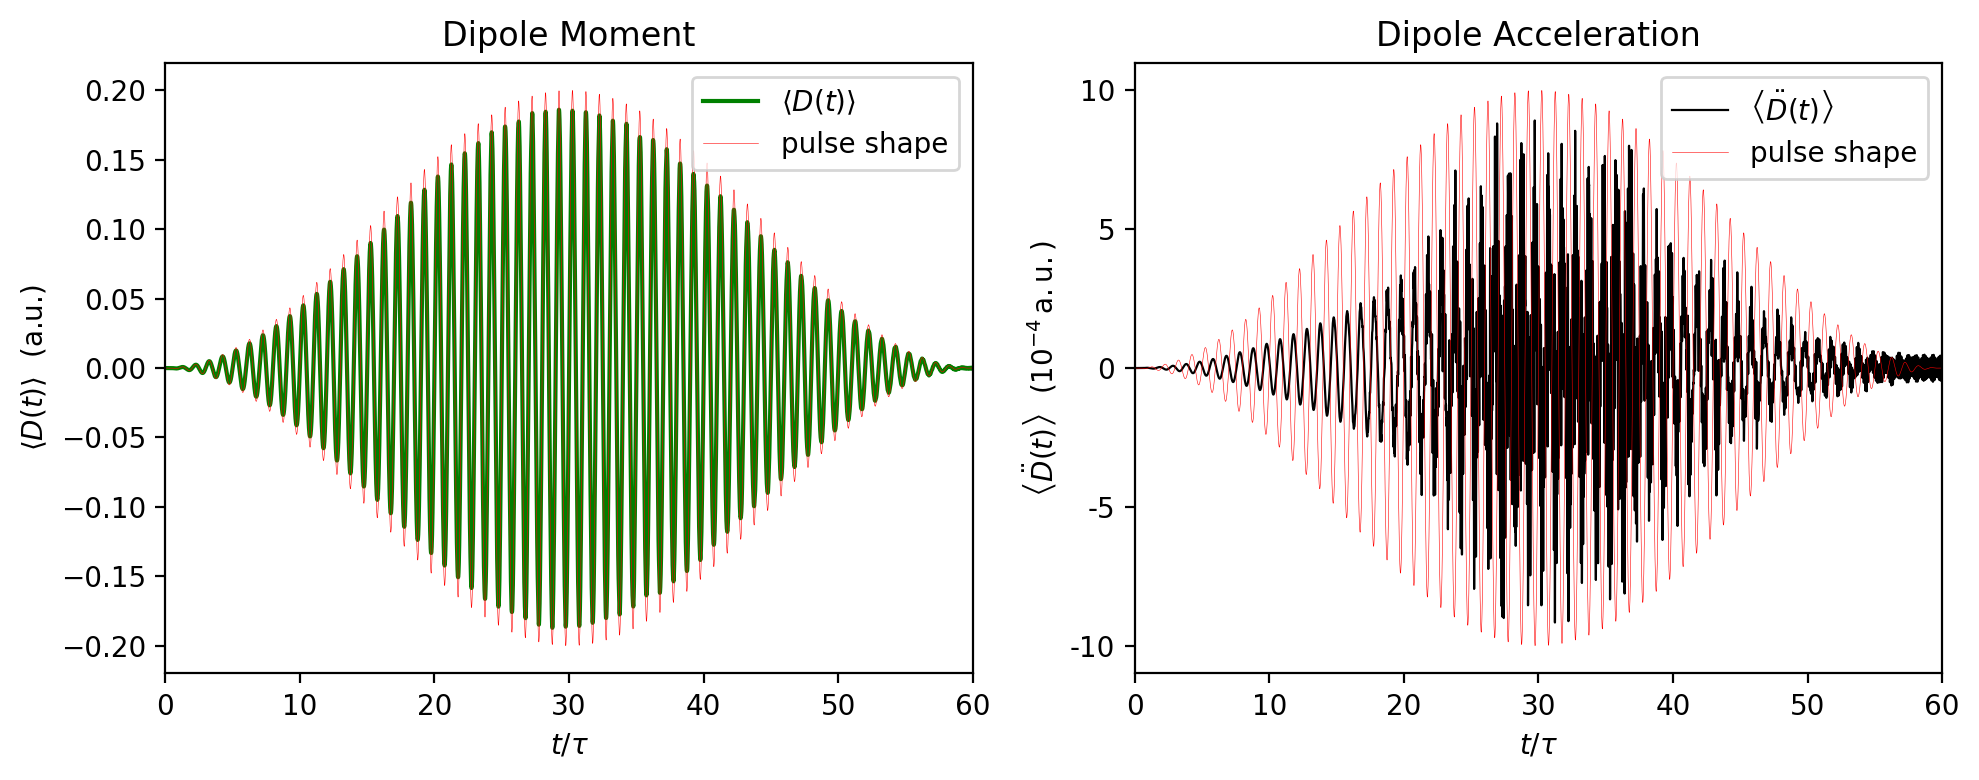

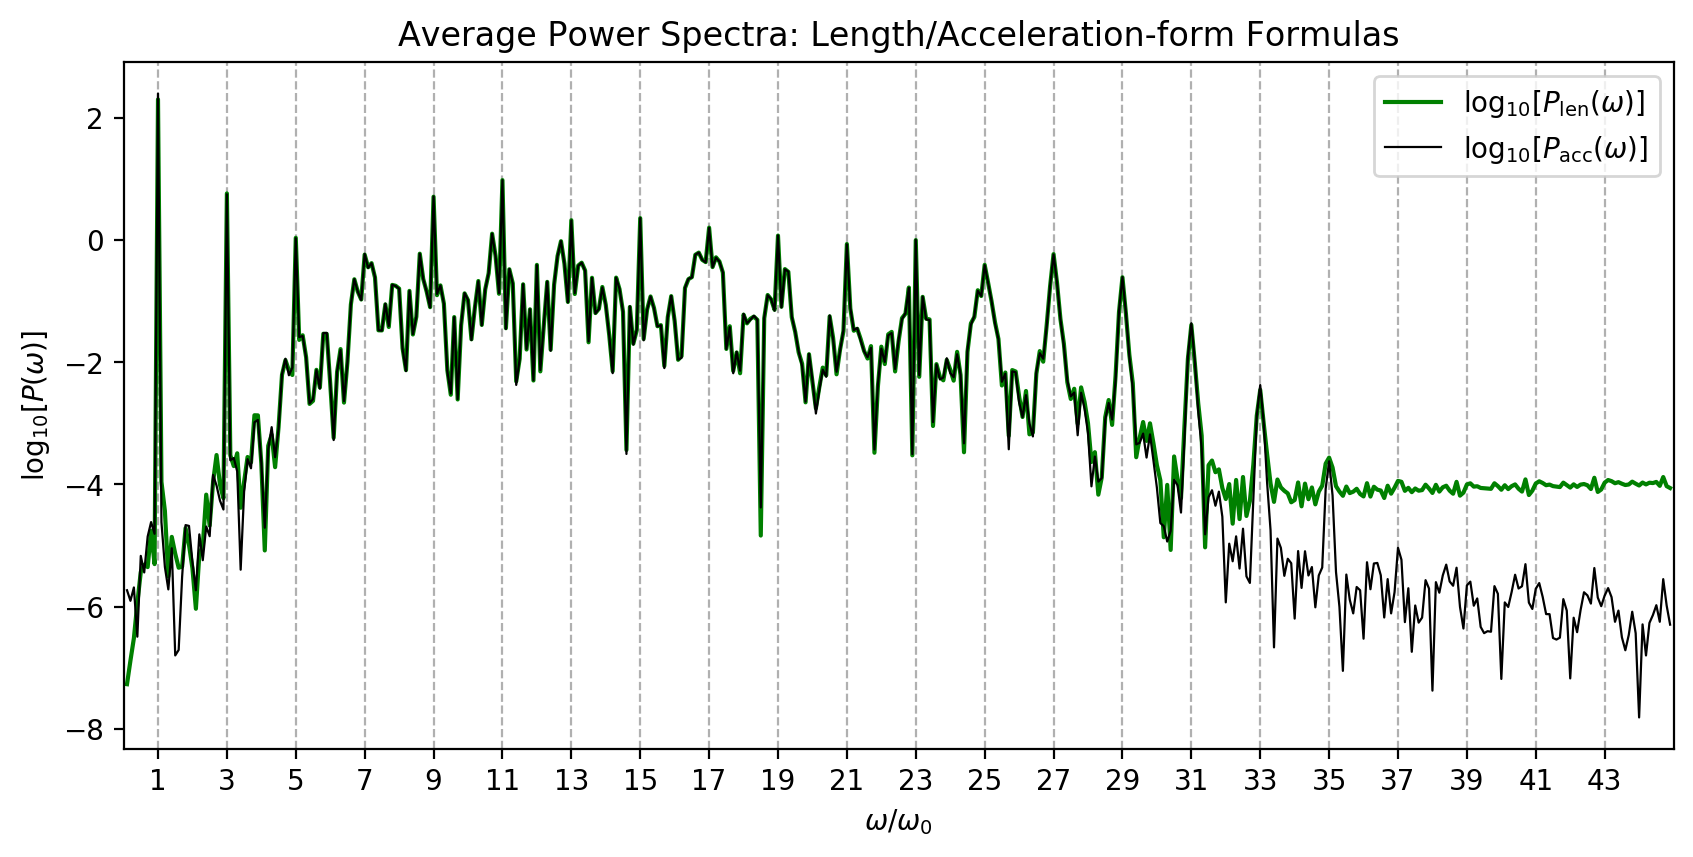

In [24]:
plt.figure(1,figsize=(10,4),dpi=200)
plt.subplot(1,2,1)
T = np.arange(len(D_len))*dt
F = lambda t: np.sin(np.pi*t/(n*τ))**2 * np.sin(ω0*t)
plt.plot(T/τ, D_len.real, 'g', label='$\left< D(t) \\right>$')
plt.plot(T/τ, 0.2*F(T), 'r', lw=0.2, label='pulse shape')
plt.xlim((0,t_max/τ))
plt.xlabel('$t/τ$')
plt.ylabel('$\left< D(t) \\right>$  (a.u.)')
plt.title('Dipole Moment')
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.plot(T/τ, D_acc.real, 'k', lw=0.8, label='$\left< { \ddot { D }  }(t) \\right>$')
plt.plot(T/τ, 1e-3*F(T), 'r', lw=0.2, label='pulse shape')
plt.xlim((0,t_max/τ))
plt.xlabel('$t/τ$')
plt.ylabel('$\left< { \ddot { D }  }(t) \\right>$  ($10^{-4}\,\mathrm{a.u.}$)')
plt.yticks([-10e-4,-5e-4,0,5e-4,10e-4], [-10,-5,0,5,10])
plt.title('Dipole Acceleration')
plt.legend(loc='upper right')
plt.tight_layout()

plt.figure(2,figsize=(10,10),dpi=200)
plt.subplot(2,1,2)
P_len = lambda ω: 4*137**3/(3*t) * abs(simps(D_len*np.exp(-1j*ω*T)*ω**2,dx=dt))**2
P_acc = lambda ω: 4*137**3/(3*t) * abs(simps(D_acc*np.exp(-1j*ω*T),dx=dt))**2
harmorder = np.arange(0.1, 45, 0.1)
harmorder.shape = (len(harmorder), 1)
plt.plot(harmorder, np.log10(P_len(harmorder*ω0)), 'g', 
         label='$\log_{ 10 }{ \left[ P_{\mathrm {len}}(\omega ) \\right] } $')
plt.plot(harmorder, np.log10(P_acc(harmorder*ω0)), 'k', 
         lw=0.8, label='$\log_{10}{\left[ P_{\mathrm {acc}}(\omega) \\right]} $')
plt.xlim((0,45))
plt.xlabel('$ω/ω_0$')
plt.ylabel('$\log_{ 10 }{ \left[ P(\omega ) \\right] } $')
plt.grid(axis='x', ls='--')
plt.xticks([2*i+1 for i in range(22)])
plt.title('Average Power Spectra: Length/Acceleration-form Formulas')
plt.legend(loc='upper right')
plt.show()

In [Ref. 1](#ref), the effects of varying some of the parameters are also discussed––the chirp parameter $c_r$ (making the pulse nonperiodic), pulse length $\frac{t}{\tau}$, and laser intensity $I$. 

The positive-chirp laser pulses, $E(t) =E_0\sin^2\left(\frac{\pi t}{n\tau}\right)\sin\left(\omega_0 t+c_rt^2\right)\quad(c_r>0)$, tend to suppress the lower-order harmonic intensities but enhance those of the higher-order harmonics. The enhancement reaches a maximum at $c_r=2.0\,\mathrm{a.u.}$ For the negative-chirp pulsed laser ($c_r<0$), there is significant suppression of the higher-order harmonics.

On the other hand, as the pulse length becomes longer, each individual harmonic peak becomes sharper. In the limit of monochromatic laser fields (infinite pulse length), the peaks get spiky. It is also seen that as the pulse length becomes shorter, all the harmonic peaks show various degrees of enhancement. This indicates that for a given laser pulse energy, the shorter laser pulses produce the most harmonic signal, i.e., the harmonic efficiency scaling inversely with pulse duration.

Lastly, at higher intensity significant ionization occurs and the HHG plateau is significantly extended. The Keldysh parameter for the presented higher-intensity case in Ref. 1 is $\gamma = 0.80$, indicating the tunneling regime is reached. The cut-off position at $\nu\approx45$ is hence consistent with that predicted by the semi-classical model.

# IV. Conclusion
In this project, we introduce the TDGPS method for the numerical solution of time-dependent Schrödinger equation and non-perturbative treatment of multiphoton ionization and high-order harmonic generation in intense laser fields. The method is found to be computationally efficient and capable of providing high-quality time-dependent wavefunctions for accurate treatment of HHG processes. Through the discussion, it is also shown that coherent control of HHG spectrum (by tuning the pulse length, chirp, and intensity of the ultrashort intense pulsed laser fields) may be feasible.

# V. References<a id="ref"></a>
1. X. M. Tong and S. I. Chu, Theoretical study of multiple high-order harmonic generation by intense ultrashort pulsed laser fields: A new generalized pseudospectral time-dependent method, *Chem. Phys.* **217**, 119–130 (1997)

2. Bruno Costa and Wai Sun Don, On the computation of high order pseudospectral derivatives, *Applied Numerical Mathematics*, Vol. 33, Issues 1–4, 2000, 151-159

3. Gottlieb, D. & Turkel, Eli. (1983). Spectral methods for time dependent partial differential equations. *Numerical Methods in Fluid Dynamics*. 1127. 